# **Homework 4_2**

Выполнил: Касенов Султан

В данной лабораторной работе мы будем использовать предобученные нейросети, чтобы классифицировать породы  кошек и собак в выбранном датасете. Однако сначала надо подготовить изображения для работы с ними. 

# **Предобработка датасета изображений и его визуализация**

Для начала импортируем все используемые библиотеки в данной работе. 



In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import os
import re
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
from PIL import Image

Теперь скачаем наш датасет.

In [ ]:
dataset = torchvision.datasets.OxfordIIITPet(root='./', download=True)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


Если проверить вкладку *Файлы* слева, то можно увидеть новую папку под названием *oxford-iiit-pet*. В ней хранятся изображения кошек и собак различных пород (породы подписаны в названиях фотографий), а также различная дополнительная информация. Для того чтобы упростить работу с изображениями, мы создадим отдельные директории для классов (пород) и переместим каждую фотографию в соответствии с породой в свою директорию.

In [ ]:
# Path to the folder containing the images
folder_path = "oxford-iiit-pet/images"

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (you can modify this to match your file extensions)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        
        sep = '_'
        # 
        if filename[0].isupper():
            class_name = 'Cat_' + filename.split(sep, 1)[0]
        else:
            class_name = 'dog_' + filename.split(sep, 1)[0]

        # Create the class folder if it doesn't exist
        class_path = os.path.join(folder_path, class_name)
        os.makedirs(class_path, exist_ok=True)
        # Move the file to the class folder
        src_path = os.path.join(folder_path, filename)
        dst_path = os.path.join(class_path, filename)
        shutil.move(src_path, dst_path)
    else:
      os.remove(os.path.join(folder_path, filename))



Когда наши изображения разделены на классы (породы) и каждая порода кошки или собаки лежит в своей соответствующей папке, нам остается разделить изображения на обучающие и тестовые. Для этого мы создаем новые директории *test и train*. Далее распределяем **80** процентов изображений в папку *train* и **20** в *test*. 

In [ ]:
# Set the path to the directory containing the class directories
data_dir = "oxford-iiit-pet/images"

# Get a list of the class directories
class_dirs = os.listdir(data_dir)

# Loop through each class directory and split the images into training and testing sets
for class_dir in class_dirs:
    # Set the path to the current class directory
    class_path = os.path.join(data_dir, class_dir)
    
    # Get a list of the image files in the class directory
    image_files = os.listdir(class_path)
    
    # Split the image files into training and testing sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
    
    # Create new directories for the training and testing sets
    train_dir = os.path.join(data_dir, 'train', class_dir)
    test_dir = os.path.join(data_dir, 'test', class_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Move the training images to the new directory
    for train_file in train_files:
        src_path = os.path.join(class_path, train_file)
        dst_path = os.path.join(train_dir, train_file)
        shutil.copy(src_path, dst_path)
        
    # Move the testing images to the new directory
    for test_file in test_files:
        src_path = os.path.join(class_path, test_file)
        dst_path = os.path.join(test_dir, test_file)
        shutil.copy(src_path, dst_path)

Подготавливаем dataloaders и функцию предобработки, которая будет выполняться для каждого изображения в батче. Также сохраняем классы в новую переменную.

In [ ]:
# define transform functions which should applied to images
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# prepare loader for train data
trainset = torchvision.datasets.ImageFolder(root='oxford-iiit-pet/images/train', transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

# prepare loader for test data
testset = torchvision.datasets.ImageFolder(root='oxford-iiit-pet/images/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

# save all classes to list
classes = class_dirs

Далее, отсортируем список классов (чтобы был такой же порядок как и в директориях) и сохраним их в виде кортежа.

In [ ]:
classes.sort()
classes = tuple(classes)
classes

Теперь проиллюстрируем один батч изображений. Ниже представлены сами изображения и в виде списка их породы в соответствующем порядке.




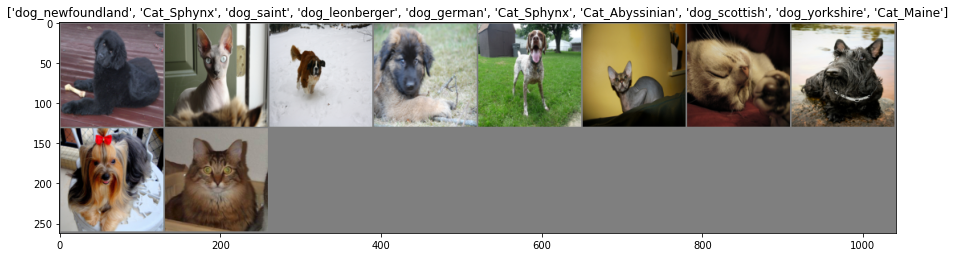

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (15,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes_id = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in classes_id])

# **Transfer learning with VGG16**

Чтобы обучить модель с хорошей точностью, мы используем уже обученную модель *VGG16*. Однако перед тем как оценивать точность, следует изменить архитектуру нейросети так, чтобы она имела кол-во выходов, равное кол-во классов, и до обучить ее на собственном датасете.

Далее мы скачиваем обученную модель.

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Переходим с CPU на GPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Можем рассмотреть архитектуру скачанной нейросети.

In [ ]:
summary(model,input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

Перед тем как менять архитектуру нейросети мы уберем возможность вычислять градиенты для весов. Чтобы в будущем при обучении на собственном датасете менять веса только измененной нами части.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

В VGG16 последний полносвязный слой называется *classifier*. Поэтому мы 
меняем его на новый слой, представленный ниже. Главная особенность - это новое кол-во выходов.

In [ ]:
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4096, 35)
    )

Пропишем функции *validate* и *train*. Первая нужна чтобы выводить точность нейросети на тестовом датасете, второй метод запускает циклы обучения нейросети.

In [ ]:
print(f'Using device={device}')

def validate(net,test_loader):
  count=acc=0
  for xo,yo in test_loader:
    x,y = xo.to(device), yo.to(device)
    with torch.no_grad():
      p = net.forward(x)
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
  return acc/count

def train(net,train_loader,test_loader,epochs=3,loss_fn=torch.nn.CrossEntropyLoss()):
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters())
  for ep in range(epochs):
    count=acc=0
    for xo,yo in train_loader:
      x = xo.to(device)
      y = yo.to(device)
      optimizer.zero_grad()
      p = net.forward(x)
      loss = loss_fn(p,y)
      loss.backward()
      optimizer.step()
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
    val_acc = validate(net,test_loader)
    print(f"Epoch={ep}, train_acc={acc/count}, val_acc={val_acc}")

Using device=cuda


Теперь начнем обучение нейросети. Следует отметить, что точность повысилась с 40 до 68 процентов, в сравнении с прошлой работой, где сеть обучалась с нуля.

In [ ]:
train(model, trainloader, testloader, 3)

Epoch=0, train_acc=0.7558788657188416, val_acc=0.6741040945053101
Epoch=1, train_acc=0.8007105588912964, val_acc=0.6734279990196228
Epoch=2, train_acc=0.8140754699707031, val_acc=0.6815415620803833


Для лучшей оценки точности построим матрицу ошибки. 

<Axes: >

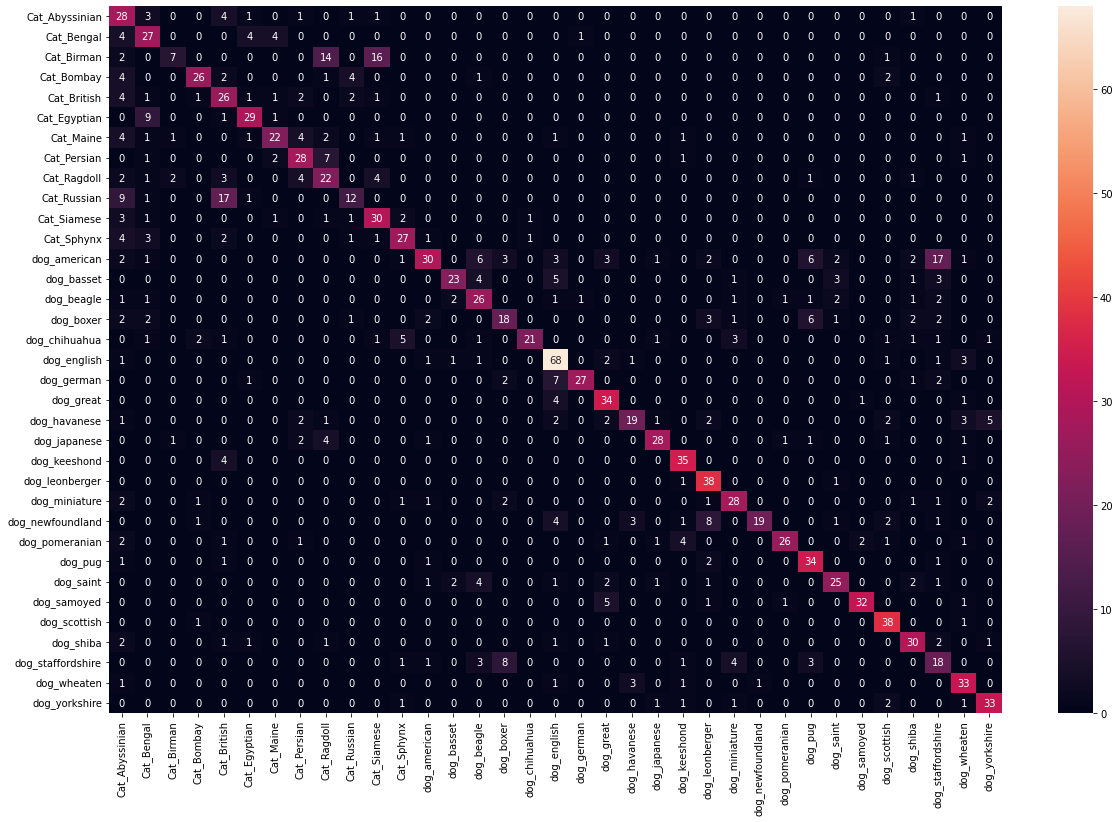

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
  
        output = model(inputs.type(torch.cuda.FloatTensor)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

# plot the matrix
plt.figure(figsize = (20,13))
sn.heatmap(df_cm, annot=True)

Теперь чтобы удобно предсказывать породы кошек и собак по фотографиям напишем две функции. Первая будет приводить фото в тензор нужного размера и нормализовывать. Вторая будет подавать тензор нейросети и на основе предсказания модели выводить топ 3 породы (вместе с вероятностью), на которые похожа кошка или собака, изображенная на фото.

image--reshape torch.Size([1, 3, 128, 128])


<ipython-input-25-f8a679a9846e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).type(torch.cuda.FloatTensor)


tensor([[[[-0.3647, -0.3725, -0.3725,  ..., -0.3725, -0.3647, -0.3647],
          [-0.3569, -0.3569, -0.3569,  ..., -0.3725, -0.3725, -0.3569],
          [-0.3647, -0.3569, -0.3412,  ..., -0.3569, -0.3647, -0.3569],
          ...,
          [-0.6000, -0.6000, -0.5922,  ..., -0.5686, -0.5922, -0.5765],
          [-0.5843, -0.5922, -0.5922,  ..., -0.5765, -0.5686, -0.5608],
          [-0.5686, -0.5765, -0.5843,  ..., -0.5608, -0.5451, -0.5451]],

         [[-0.4039, -0.3961, -0.3961,  ..., -0.4196, -0.4118, -0.4118],
          [-0.4039, -0.3961, -0.3961,  ..., -0.4118, -0.4039, -0.4039],
          [-0.4039, -0.4039, -0.3961,  ..., -0.3961, -0.3882, -0.4118],
          ...,
          [-0.6314, -0.6314, -0.6314,  ..., -0.6235, -0.6314, -0.6314],
          [-0.6235, -0.6235, -0.6235,  ..., -0.6235, -0.6235, -0.6235],
          [-0.6157, -0.6235, -0.6157,  ..., -0.6157, -0.6078, -0.6157]],

         [[-0.4353, -0.4353, -0.4353,  ..., -0.4196, -0.4118, -0.4118],
          [-0.4196, -0.4118, -

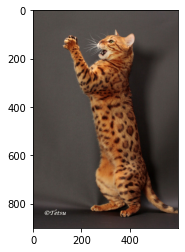

In [ ]:
def image_prep(img_path):

  # read the image
  image = Image.open(img_path)
  
  # plot the image
  plt.imshow(image)

  # apply transform functions
  image = transform(image)

  # convert to tensor and add 1 dimension to create batch with size = 1
  image = torch.tensor(image).type(torch.cuda.FloatTensor)
  image = image[None, :, :, :]
  print("image--reshape",image.shape)
  return image

image_prep('oxford-iiit-pet/images/Cat_Bengal/Bengal_1.jpg')

<ipython-input-25-f8a679a9846e>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).type(torch.cuda.FloatTensor)


image--reshape torch.Size([1, 3, 128, 128])

_____top 3_____

dog_pug: 0.9981430768966675
dog_boxer: 0.0017854191828519106
Cat_Siamese: 5.178514766157605e-05


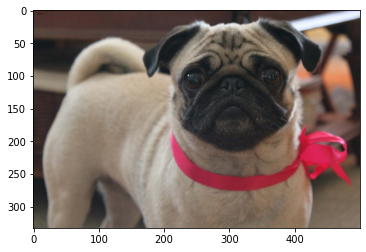

In [ ]:
def predict(model, img_path, classes):
  acc = {}

  # preprocessing image
  img = image_prep(img_path)

  # predict classes
  m = nn.Softmax(dim=-1)
  pred = m(model.forward(img).flatten())

  # find top 3 values
  indices = torch.topk(pred, 3).indices

  # create and return list with classes
  for i in indices:
    acc[classes[i]] = pred[i]
  return acc

# test predict function
top3 = predict(model, 'oxford-iiit-pet/images/test/dog_pug/pug_71.jpg', classes)
print('\n_____top 3_____\n')

for i in top3.keys():
  print(f"{i}: {top3[i]}")

# **Transfer learning with RESNET50**

Теперь используем другую более богатую модель *RESNET 50*.

***По какой-то причине модель не обучается...***

In [ ]:
model1 = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model1 = model1.to(device)

summary(model1,input_size=(3, 128, 128))

In [ ]:
for param in model1.parameters():
    param.requires_grad = False

In [ ]:
model1.fc = nn.Sequential(
    nn.Linear(2048, 1096),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1096, 35)
    )

In [ ]:
train(model1, trainloader, testloader, 3)

Epoch=0, train_acc=0.5220775008201599, val_acc=0.05544286593794823
Epoch=1, train_acc=0.6460835933685303, val_acc=0.05611899867653847
Epoch=2, train_acc=0.6643546223640442, val_acc=0.0649087205529213


In [ ]:
model1.parameters

# **Transfer learning for 2 classes** 
В завершении работы хотелось бы оценить точность предобученных моделей в бинарной классификации между кошкой и собакой. Для этого создадим новые директории с именами: train_bin, test_bin. Далее распределим 80 процентов кошек и собак по двум соответсвтующим папкам (сats and dogs) внутри дирректории train_bin. Остальную часть кошек и собак в test_bin.

In [ ]:
# create directoiries for train and test data
dog_dir_train = os.path.join(data_dir, 'train_bin', 'dogs')
os.makedirs(dog_dir_train, exist_ok=True)

cat_dir_train = os.path.join(data_dir, 'train_bin', 'cats')
os.makedirs(cat_dir_train, exist_ok=True)

dog_dir_test = os.path.join(data_dir, 'test_bin', 'dogs')
os.makedirs(dog_dir_test, exist_ok=True)

cat_dir_test = os.path.join(data_dir, 'test_bin', 'cats')
os.makedirs(cat_dir_test, exist_ok=True)

# Loop through each class directory and split the images into training and testing sets
for class_dir in class_dirs:    
    # Set the path to the current class directory
    class_path = os.path.join(data_dir, class_dir)

    # skip created directories from the previous part 
    if 'train' in class_path or 'test' in class_path:
      continue

    # Get a list of the image files in the class directory
    image_files = os.listdir(class_path)

    # Split the image files into training and testing sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)


    # move images to train or test direcotries
    if 'dog' in class_dir:
      for img in train_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, dog_dir_train)

      for img in test_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, dog_dir_test)
    else:
      for img in train_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, cat_dir_train)

      for img in test_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, cat_dir_test)

Теперь делаем все тоже самое, что и в предыдущих частях.


1.   Создаем объекты dataLoaders, которые будут загружать фотографии в нейросеть.
2.   Скачиваем обученную модель *VGG16* 
3.   Строим архитектуру нейросети в которой меняется кол-во конечных выходов с 35 до 2 (т.к. используется бинарная классификация).
4.   Обучаем и строим матрицу ошибки новой нейросети.

In [ ]:
# prepare loader for the train data
trainset = torchvision.datasets.ImageFolder(root='oxford-iiit-pet/images/train_bin', transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

# prepare loader for the test data
testset = torchvision.datasets.ImageFolder(root='oxford-iiit-pet/images/test_bin', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

# save all classes in the tuple
classes = ('cats', 'dogs')

In [ ]:
model2 = torchvision.models.vgg16(pretrained=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = model2.to(device)

for param in model2.parameters():
    param.requires_grad = False

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model2.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4096, 2)
    ).to(device)

In [ ]:
train(model2, trainloader, testloader, 5)

Epoch=0, train_acc=0.9825748801231384, val_acc=0.9675456285476685
Epoch=1, train_acc=0.9846049547195435, val_acc=0.9621365666389465
Epoch=2, train_acc=0.9851124882698059, val_acc=0.9621365666389465


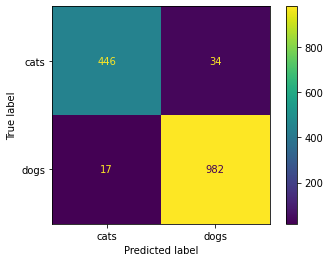

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model2(inputs.type(torch.cuda.FloatTensor)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=classes)

disp.plot()